In [2]:

import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io as sio
import csv
import math
from scipy.special import erf

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import NullFormatter
import matplotlib

from snsphd import viz

_ = viz.phd_style(jupyterStyle=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
RCWA = sio.loadmat(os.path.join('',"../data/Be190226_2__1xAR_1550nm_W100_P500_NWthk7.mat" ))
shortpass = sio.loadmat("../data/AndoverFilters.mat")
BK7_1mm = sio.loadmat('../data/BK7_1mm.mat')
BK7_10mm = sio.loadmat('../data/bk7_10mm.mat')

BK7_1mm_wl = BK7_1mm["wlBK7"][:,0]
BK7_1mm_trans = BK7_1mm["transBK7"][:,0]

BK7_10mm_wl = BK7_10mm['bk7'][:,0]/1e9
BK7_10mm_trans = BK7_10mm['bk7'][:,1]/100

In [4]:
RCWA_AbsTE = RCWA['AbsTE'][0]
RCWA_AbsTM = RCWA['AbsTM'][0]
RCWA_stackDesign = RCWA['stackDesign'][0]
RCWA_wl = RCWA['wavelengthArray'][0]
RCWA_AbsMean = np.mean([RCWA_AbsTE,RCWA_AbsTM], axis = 0)

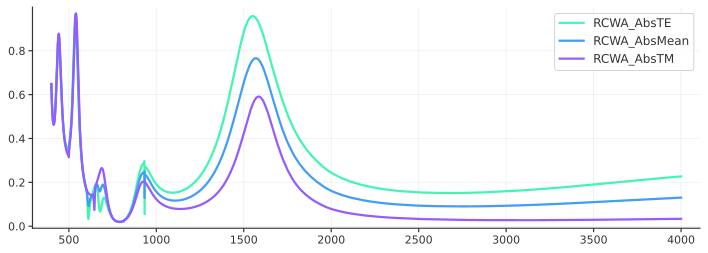

In [42]:
c1 = "#42f5b3"
c2 = "#429ef5"
c3 = "#955cff"

fig = plt.figure(figsize = (12,4))
ax = fig.add_subplot(1,1,1)
ax.plot(RCWA_wl, RCWA_AbsTE, label='RCWA_AbsTE', color = c1)
ax.plot(RCWA_wl, RCWA_AbsMean, label='RCWA_AbsMean', color = c2)
ax.plot(RCWA_wl, RCWA_AbsTM, label='RCWA_AbsTM', color = c3)
ax.grid(True, which="both", axis = "x", ls="-")
ax.grid(True, which="both", axis = "y", ls="-")
ax.legend()
plt.savefig("../figs/RCWA.svg", format = "svg", transparent = True)
plt.show()


In [6]:
trans15714 = shortpass['trans15714'][0]/100
trans15715 = shortpass['trans15715'][0]/100
wl15714 = shortpass['wl15714'][0]
wl15715 = shortpass['wl15715'][0]
#trans15714 = np.flip(trans15714)/100
#trans15715 = np.flip(trans15715)/100

indx= np.flip(np.arange(1,len(wl15714) + 1))
wl = np.flip(wl15714)*1e-6

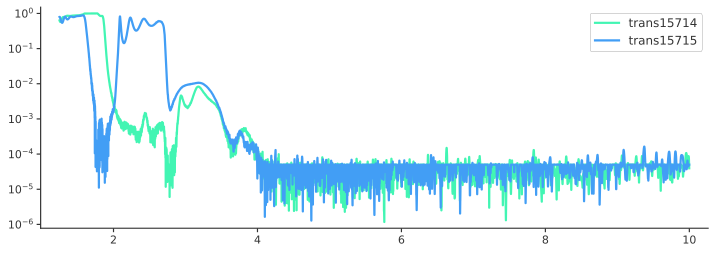

In [12]:
fig = plt.figure(figsize = (12,4))
ax = fig.add_subplot(1,1,1)
ax.plot(wl15714, trans15714, label='trans15714', color = c1)
ax.plot(wl15715, trans15715, label='trans15715', color = c2)
ax.legend()
ax.set_yscale('log')

In [9]:
bandpass_wl = []
bandpass_t = []

with open('../data/NIR01-1550_3_Spectrum_1.txt', 'r') as f:
    reader = csv.reader(f,delimiter='\t')
    for i, row in enumerate(reader):
            #print(row[1])
            bandpass_wl.append(float(row[0]))
            bandpass_t.append(float(row[1]))
            
bandpass_wl = np.array(bandpass_wl)
bandpass_t = np.array(bandpass_t)

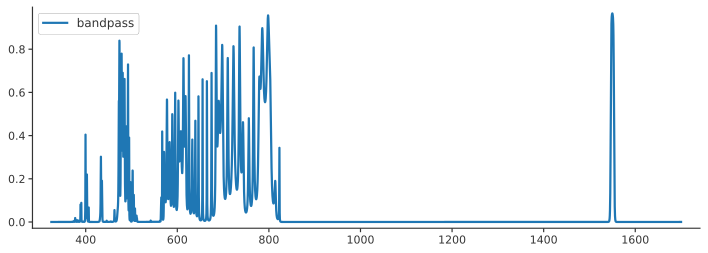

In [13]:
fig, ax = plt.subplots(figsize = (12,4))
ax.plot(bandpass_wl, bandpass_t, label='bandpass')
ax.legend()

In [14]:
c=3e8
h=6.626e-34
kB=1.38e-23
T=290
T1=295
T2=300

half_angle = math.atan(4/18) #radius of aperture is 4mm, lens is f=18mm 
q2=0.140

freq = np.zeros(len(wl15714))
freq = c/wl
diffs = np.diff(freq)

Begin = c/(300e-9)
End = freq[-1]
Spacing = -np.mean(diffs)
n = int((Begin - End)//Spacing)
FREQ = np.linspace(Begin,End, n)
WL = c/FREQ

In [15]:
trans = np.flip(trans15714*trans15715)  #one of each
trans0 = np.flip((trans15714**2)*(trans15715**2))  #two of each
trans1 = np.flip((trans15714**3)*(trans15715**3))  #three of each


trans15714 = np.flip(trans15714)  
trans15715 = np.flip(trans15715)


In [16]:
Sim = False

if Sim:
    end_vals = 1
else:
    end_vals = np.NaN

TRANS15714 = np.interp(WL,wl, trans15714, left=end_vals, right=end_vals)
TRANS15715 = np.interp(WL,wl, trans15715, left=end_vals, right=end_vals)  
    
TRANS = np.interp(WL,wl, trans, left=end_vals, right=end_vals)
TRANS0 = np.interp(WL,wl, trans0, left=end_vals, right=end_vals)
TRANS1 = np.interp(WL,wl, trans1, left=end_vals, right=end_vals)

BK7_10mm_interp = np.interp(WL,BK7_10mm_wl,BK7_10mm_trans,left=end_vals, right=end_vals)
BE190226 = np.interp(WL,RCWA_wl/1e9, RCWA_AbsMean)
BE190226_TE = np.interp(WL,RCWA_wl/1e9, RCWA_AbsTE)
BE190226_TM = np.interp(WL,RCWA_wl/1e9, RCWA_AbsTM)


BANDPASS = np.interp(WL, bandpass_wl/1e9, bandpass_t, left=end_vals, right=end_vals)


In [17]:
b = np.zeros(len(WL))
cc = np.zeros(len(WL))
ind = np.where(WL>2.78e-6)[0]
b[ind] = 0.1344*(WL[ind]*1e6-2.78)+.781
ind = np.where(WL<=2.78e-6)[0]
b[ind] = 0.1344*(WL[ind]*1e6-2.78)+.781
b = 4.816*(WL*1e6)**(0.07896) - 4.427
cc = 0.01*(WL*1e6-1.55)+0.09543
etaint = 0.5+0.5*erf((0.8-b)/cc)

In [18]:
# colors
a1 = "#A7226E"
a2 = "#EC2049"
a3 = "#F26B38"

a4 = "#6ba8c7"
a5 = "#7090d4"
a6 = "#8170d4"

c1 = "#42f5b3"
c2 = "#429ef5"
c3 = "#955cff"

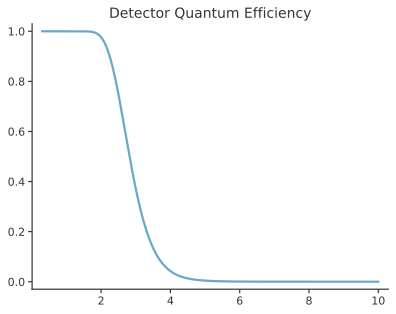

In [19]:
plt.plot(WL*1e6, etaint, label='Detector Sensitivity', color = a4)
_ = plt.title("Detector Quantum Efficiency")

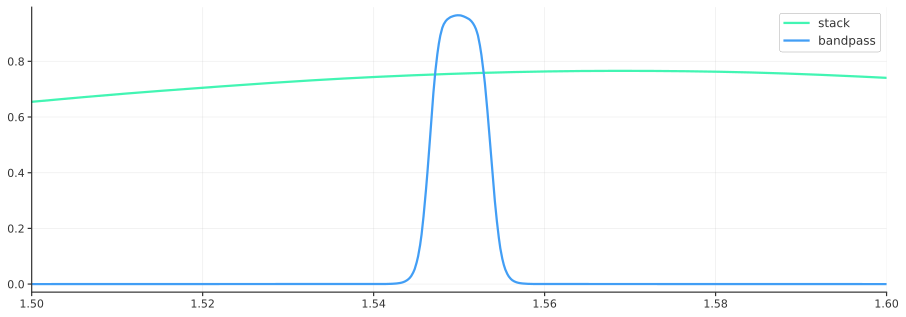

In [43]:
fig = plt.figure(figsize = (12*1.1,4*1.1))
#ax = fig.add_subplot(1,1,1)
border_width = 0.05
ax_size = [0+border_width, 0+border_width, 
               1-2*border_width, 1-2*border_width]
ax = fig.add_axes(ax_size)


ax.plot(WL*1e6, BE190226, label='stack',color = c1)
ax.plot(WL*1e6, BANDPASS, label='bandpass',color = c2)
#ax.plot(WL*1e6, BK7_10mm_interp, label='10mm BK7',color = lin_color_3)
#ax.plot(wl15715, trans15715, label='trans15715')
ax.legend(loc = 'upper right')
ax.grid(True, which="both", axis = "x", ls="-")
ax.grid(True, which="both", axis = "y", ls="-")

ax.set_xlim(1.500,1.600)

# plt.savefig("testing2.pdf", format = "pdf", transparent = True)
plt.show()

In [21]:
b = np.zeros(len(WL))
cc = np.zeros(len(WL))
ind = np.where(WL>2.78e-6)[0]
b[ind] = 0.1344*(WL[ind]*1e6-2.78)+.781
ind = np.where(WL<=2.78e-6)[0]
b[ind] = 0.1344*(WL[ind]*1e6-2.78)+.781
b = 4.816*(WL*1e6)**(0.07896) - 4.427
cc = 0.01*(WL*1e6-1.55)+0.09543
etaint = 0.5+0.5*erf((0.8-b)/cc)

Text(-0.03, 1.01, 'c)')

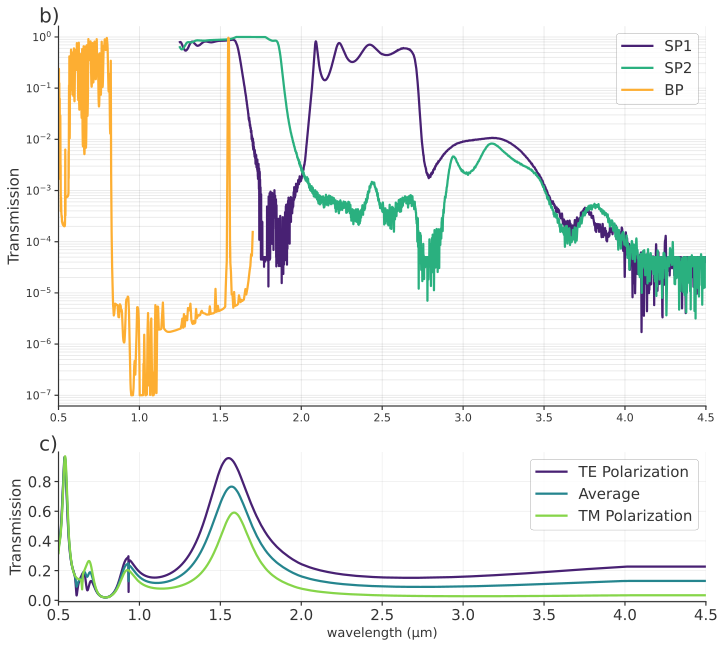

In [23]:
from snsphd.layout import bisect

font_small = 13 
font_med = 18
font_large = 20 
spacing = 0.03

n_lines = 12
x = np.linspace(0, 10)
phase_shift = np.linspace(0, np.pi, n_lines)
color_idx = np.linspace(0, 1, n_lines)

DCR1 = 1
DCR2 = 4
DCR3 = 7
DCR5 = 1

Fiber_Color_1 = "#787878"
Fiber_Color_2 = "#242424"

red = plt.cm.plasma(color_idx[9]) #"#fc3232"

b1 = plt.cm.viridis(color_idx[DCR1]) #"#1dbdc2"
b2 = plt.cm.viridis(color_idx[DCR3]) #"#1dc29e"
b3 = "#1dc2a7"

g1 = "#edad24"
g2 = "#e85520"
    

thick = 1
bg_color = (.16,.16,.16)
minor_grid_color = (.9,.9,.9)
lin_color_1 = "#21b8a9"
lin_color_2 = "#d44f46"
border_color = (1,1,1)
figure_size = (9,8)
fig = plt.figure(figsize = figure_size)
border = 0.09


ax2_size, ax1_size = bisect([0,0,1,1], direction='horiz',offset=0.3, spacing=0.08)
ax1 = fig.add_axes(ax1_size)
ax2 = fig.add_axes(ax2_size,sharex=ax1)

# matplotlib.rcParams['axes.linewidth'] = thick

ax_sub_Med = -2
ax_sub_Cold = -2
ax_sub_FC = -2
msize = 3
lwidth = 5
# plt.rcParams['lines.linewidth'] = 2.5
# plt.rcParams['axes.spines.right'] = False
# plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.linewidth'] = 1.2
# plt.rcParams['axes.facecolor'] = (1,1,1,1)
# plt.rcParams['legend.facecolor'] = (0.93,0.93,0.93,.5)
# #plt.rcParams['axes.patch.alpha'] = 0.3
# plt.rcParams['svg.fonttype'] = 'path'
# # plt.rcParams['font.sans-serif'] = ['Montserrat']
# plt.rcParams["font.weight"] = "500"



a1 = "#A7226E"
a2 = "#EC2049"
a3 = "#F26B38"

a4 = "#6ba8c7"
a5 = "#7090d4"
a6 = "#8170d4"


v1 = "#12c767"
v2 = "#12c7c7"
v3 = "#2b9ae3"

v4 = "#f24438"


d1 = "#6737ed"
d2 = "#d44bdb"
d3 = "#db4b95"


fsize = 15

border_color = (1,1,1)
figure_size = (12,20)


ax1.plot(WL*1e6, TRANS15715, color = b1, label = "SP1") #"1.9 $\mathrm{\mu m}$ shortpass"
ax1.plot(WL*1e6, TRANS15714, color = b2, label = "SP2") #"1.6 $\mathrm{\mu m}$ shortpass"
ax1.plot(WL*1e6, BANDPASS, color = red, label = "BP") #"1550nm bandpass"
ax1.legend(fontsize = fsize)


ax1.grid(True, which="both", axis = "x", ls="-", color = (0,0,0),alpha = .1)
ax1.grid(True, which="both", axis = "y", ls="-", color = (0,0,0), alpha = .1)
#ax1.set_xlabel("wavelength ($\mathrm{\mu m}$)")
ax1.set_ylabel("Transmission", fontsize=fsize)

ax1.set_yscale('log')
ax1.set_xlim(0.5,4.5)
#ax.set_ylim(1e-6,3)


ax2.plot(WL*1e6,BE190226_TE, color = plt.cm.viridis(color_idx[1]), label = "TE Polarization")
ax2.plot(WL*1e6, BE190226, color = plt.cm.viridis(color_idx[5]), label ="Average")
ax2.plot(WL*1e6,BE190226_TM, color = plt.cm.viridis(color_idx[9]), label ="TM Polarization")
ax2.grid()
ax2.set_ylabel("Transmission", fontsize=fsize)
ax2.set_xlabel("wavelength ($\mathrm{\mu m}$)")
ax2.legend(fontsize = fsize)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


ax1.text(-0.03, 1.01, 'b)', fontsize=20, transform=ax1.transAxes,)
ax2.text(-0.03, 1.01, 'c)', fontsize=20, transform=ax2.transAxes,)


# viz.save_light_dark_all(fig, "../figs/filter_spectrums_thesis")

In [24]:
solid_angle = math.pi*math.sin(half_angle)**2; 
d_area = (25e-6)*(10e-6); #square detector

def Bw(T):
    return 2*h*c**2/WL**5/(np.exp(h*c/(WL*kB*T))-1)

def Nph(T):
    return solid_angle*d_area*(WL/(h*c))*Bw(T)

In [25]:
Nphw270 = Nph(270)
Nphw280 = Nph(280)
Nphw290 = Nph(290)
Nphw293 = Nph(293)
Nphw295 = Nph(295)
Nphw300 = Nph(300)
Nphw271 = Nph(271)
Nphw298 = Nph(298)

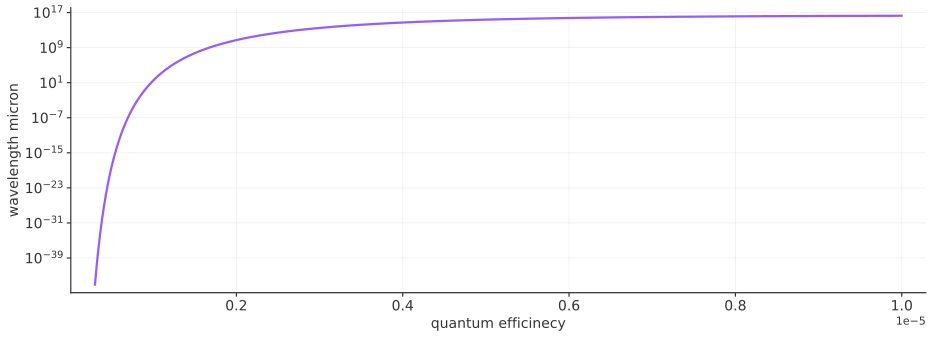

In [26]:
fig = plt.figure(figsize = (12*1.1,4*1.1))
border_width = 0.05
ax_size = [0+border_width, 0+border_width, 
               1-2*border_width, 1-2*border_width]
ax = fig.add_axes(ax_size)
ax.plot(WL, Nphw300, color = c3)
ax.grid(True, which="both", axis = "x", ls="-")
ax.grid(True, which="both", axis = "y", ls="-")
ax.set_xlabel("quantum efficinecy", fontsize=14)
ax.set_ylabel("wavelength micron", fontsize=14)
ax.set_yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [27]:
final_flux270 = etaint*BE190226*TRANS1*Nphw270*BANDPASS
final_flux280 = etaint*BE190226*TRANS1*Nphw280*BANDPASS
final_flux290 = etaint*BE190226*TRANS1*Nphw290*BANDPASS
final_flux295 = etaint*BE190226*TRANS1*Nphw295*BANDPASS
final_flux300 = etaint*BE190226*TRANS1*Nphw300*BANDPASS
final_flux293 = etaint*BE190226*TRANS1*Nphw293*BANDPASS
final_flux271 = etaint*BE190226*TRANS1*Nphw271*BANDPASS
final_flux298 = etaint*BE190226*TRANS1*Nphw298*BANDPASS

# without bandpass filter
final_flux270nb = etaint*BE190226*TRANS1*Nphw270
final_flux280nb = etaint*BE190226*TRANS1*Nphw280
final_flux290nb = etaint*BE190226*TRANS1*Nphw290
final_flux295nb = etaint*BE190226*TRANS1*Nphw295
final_flux300nb = etaint*BE190226*TRANS1*Nphw300
final_flux293nb = etaint*BE190226*TRANS1*Nphw293
final_flux271nb = etaint*BE190226*TRANS1*Nphw271
final_flux298nb = etaint*BE190226*TRANS1*Nphw298


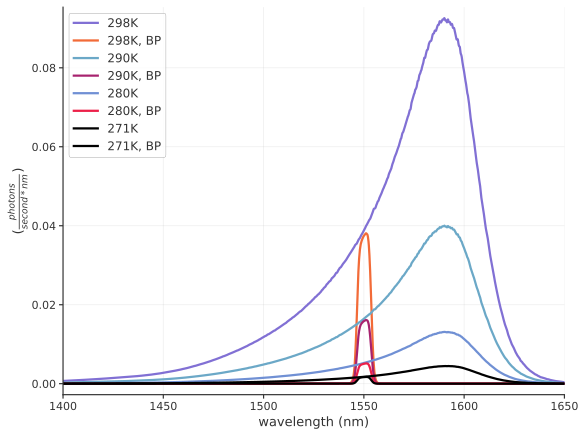

In [28]:
font_small = 13 
font_med = 18
font_large = 20 
spacing = 0.03

n_lines = 12
x = np.linspace(0, 10)
phase_shift = np.linspace(0, np.pi, n_lines)
color_idx = np.linspace(0, 1, n_lines)

DCR1 = 1
DCR2 = 4
DCR3 = 7
DCR5 = 1

Fiber_Color_1 = "#787878"
Fiber_Color_2 = "#242424"

thick = 1
bg_color = (.16,.16,.16)
minor_grid_color = (.9,.9,.9)
lin_color_1 = "#21b8a9"
lin_color_2 = "#d44f46"
border_color = (1,1,1)
figure_size = (9,7)


fig, ax = plt.subplots(1,1, figsize=figure_size)
border = 0.09
#spacing = 0.03
height = (1-2*border-spacing)/3
width = 1-2*border


ax_sub_Med = -2
ax_sub_Cold = -2
ax_sub_FC = -2
msize = 3
lwidth = 5


a1 = "#A7226E"
a2 = "#EC2049"
a3 = "#F26B38"

a4 = "#6ba8c7"
a5 = "#7090d4"
a6 = "#8170d4"

border_width = 0.15


ax.plot(WL*1e9, final_flux298nb/1e9, label='298K',color = a6)
ax.plot(WL*1e9, final_flux298/1e9, label='298K, BP',color = a3)
ax.plot(WL*1e9, final_flux290nb/1e9, label='290K',color = a4)
ax.plot(WL*1e9, final_flux290/1e9, label='290K, BP',color = a1)
ax.plot(WL*1e9, final_flux280nb/1e9, label='280K',color = a5)
ax.plot(WL*1e9, final_flux280/1e9, label='280K, BP',color = a2)
ax.plot(WL*1e9, final_flux271nb/1e9, label='271K',color = 'black')
ax.plot(WL*1e9, final_flux271/1e9, label='271K, BP', color= 'black')

ax.set_xlim(1400,1650)
ax.grid()
ax.set_xlabel("wavelength (nm)")
ax.set_ylabel(r'$(\frac{photons}{second*nm})$')
ax.legend()






In [29]:
Final280nb = np.nansum(final_flux280nb[1:]*np.diff(WL))
Final290nb = np.nansum(final_flux290nb[1:]*np.diff(WL))
Final293nb = np.nansum(final_flux293nb[1:]*np.diff(WL))
Final300nb = np.nansum(final_flux300nb[1:]*np.diff(WL))

Final271nb = np.nansum(final_flux271nb[1:]*np.diff(WL))

Final298nb = np.nansum(final_flux298nb[1:]*np.diff(WL))


print("Nph/s at 298K: ",Final298nb)
print("Nph/s at 290K: ",Final290nb)
print("Nph/s at 280K: ",Final280nb)
print("Nph/s at 271K: ",Final271nb)


Nph/s at 298K:  6.069553203047122
Nph/s at 290K:  2.5910785144832365
Nph/s at 280K:  0.8356025179506553
Nph/s at 271K:  0.28118111637352083


In [30]:
Final280 = np.nansum(final_flux280[1:]*np.diff(WL))
Final290 = np.nansum(final_flux290[1:]*np.diff(WL))
Final300 = np.nansum(final_flux300[1:]*np.diff(WL))
Final298 = np.nansum(final_flux298[1:]*np.diff(WL))
Final271 = np.nansum(final_flux271[1:]*np.diff(WL))


print("Nph/s at 298K: ",Final298)
print("Nph/s at 290K: ",Final290)
print("Nph/s at 280K: ",Final280)
print("Nph/s at 271K: ",Final271)

Nph/s at 298K:  0.27249784150608053
Nph/s at 290K:  0.11529248470267171
Nph/s at 280K:  0.0367139597955391
Nph/s at 271K:  0.01219554221968946


Figure(1500x1000)
Axes(0,0;1x1)


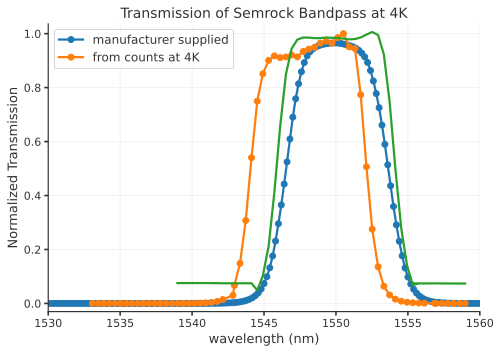

In [39]:

bp_name = "../data/bandpass_transmission.csv"
ph = []
wl = []
with open(bp_name, 'r') as f:
    reader = csv.reader(f,delimiter=',')
    for line in reader:
        wl.append(float(line[0]))
        ph.append(int(line[1]))
        

bp_rt_name = "../data/bandpass_transmission_room_temp_if.csv"
wlroom = []
power_room = []
with open(bp_rt_name, 'r') as f:
    reader = csv.reader(f,delimiter=',')
    next(reader)
    for line in reader:
        wlroom.append(float(line[1]))
        power_room.append(float(line[2])/float(line[3]))
               
m = max(ph)
ph = [p/m for p in ph]
        

font_small = 13
font_med = 15
font_large = 17


thick = 1.6
bg_color = (.16,.16,.16)
minor_grid_color = (.9,.9,.9)
lin_color_1 = "#21b8a9"
lin_color_2 = "#d44f46"

bandpass_wl = np.array(bandpass_wl)
wl = np.array(wl)
wlroom = np.array(wlroom)
power_room = np.array(power_room)

border_color = (1,1,1)
figure_size = (6,4)


fig = plt.figure(figsize = figure_size)
print(fig)
ax1 = fig.add_axes([0,0,1,1])
print(ax1)
ax1.plot(bandpass_wl, bandpass_t, label='manufacturer supplied', marker='o')
ax1.plot(wl, ph, label='from counts at 4K', marker='o')
ax1.plot(wlroom, power_room)


ax1.grid(True, which="both", axis = "x", ls="-")
ax1.grid(True, which="both", axis = "y", ls="-")
ax1.xaxis.set_tick_params(width=thick, which = "both")
ax1.yaxis.set_tick_params(width=thick, which = "both")

ax1.set_ylabel("Normalized Transmission")
ax1.set_xlabel("wavelength (nm)")
ax1.set_title("Transmission of Semrock Bandpass at 4K")
ax1.set_xlim([1530,1560])
ax1.legend()



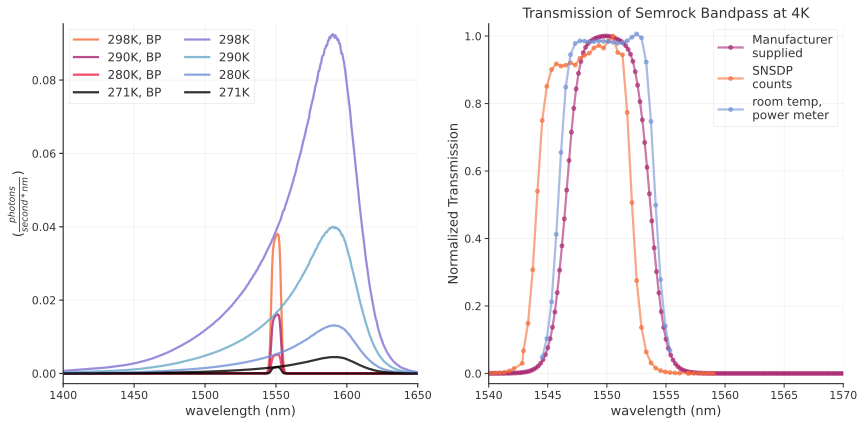

In [41]:
font_small = 13 
font_med = 18
font_large = 20 
spacing = 0.03

n_lines = 12
x = np.linspace(0, 10)
phase_shift = np.linspace(0, np.pi, n_lines)
color_idx = np.linspace(0, 1, n_lines)

DCR1 = 1
DCR2 = 4
DCR3 = 7
DCR5 = 1

Fiber_Color_1 = "#787878"
Fiber_Color_2 = "#242424"

thick = 1
bg_color = (.16,.16,.16)
minor_grid_color = (.9,.9,.9)
lin_color_1 = "#21b8a9"
lin_color_2 = "#d44f46"
border_color = (1,1,1)
figure_size = (14,6.5)


fig, axs = plt.subplots(1,2, figsize=figure_size)
border = 0.09
height = (1-2*border-spacing)/3
width = 1-2*border


ax_sub_Med = -2
ax_sub_Cold = -2
ax_sub_FC = -2
msize = 3
lwidth = 5


a1 = "#A7226E"
a2 = "#EC2049"
a3 = "#F26B38"

a4 = "#6ba8c7"
a5 = "#7090d4"
a6 = "#8170d4"

border_width = 0.15




axs[0].plot(WL*1e9, final_flux298/1e9, label='298K, BP',color = a3, alpha=0.8)
axs[0].plot(WL*1e9, final_flux290/1e9, label='290K, BP',color = a1, alpha=0.8)
axs[0].plot(WL*1e9, final_flux280/1e9, label='280K, BP',color = a2, alpha=0.8)
axs[0].plot(WL*1e9, final_flux271/1e9, label='271K, BP', color= 'black', alpha=0.8)
axs[0].plot(WL*1e9, final_flux298nb/1e9, label='298K',color = a6, alpha=0.8)
axs[0].plot(WL*1e9, final_flux290nb/1e9, label='290K',color = a4, alpha=0.8)
axs[0].plot(WL*1e9, final_flux280nb/1e9, label='280K',color = a5, alpha=0.8)
axs[0].plot(WL*1e9, final_flux271nb/1e9, label='271K',color = 'black', alpha=0.8)


axs[0].set_xlim(1400,1650)
#ax.set_xlim(1000,6000)
#ax.set_ylim(-.005,.12)
axs[0].grid()
axs[0].set_xlabel("wavelength (nm)")
axs[0].set_ylabel(r'$(\frac{photons}{second*nm})$')
axs[0].legend(ncols=2, fancybox=False, framealpha=0.3)



axs[1].plot(bandpass_wl, np.array(bandpass_t)/np.max(bandpass_t), label='Manufacturer\nsupplied', marker='o', color=a1, alpha=0.6, markersize=4)
axs[1].plot(wl, ph, label='SNSDP\ncounts', marker='o', color=a3, alpha=0.6, markersize=4)
axs[1].plot(wlroom[9:-14], power_room[9:-14], label="room temp,\npower meter", marker='o', color=a5, alpha=0.6, markersize=4)


axs[1].grid(True, which="both", axis = "x", ls="-")
axs[1].grid(True, which="both", axis = "y", ls="-")
axs[1].xaxis.set_tick_params(width=thick, which = "both")
axs[1].yaxis.set_tick_params(width=thick, which = "both")

axs[1].set_ylabel("Normalized Transmission")
axs[1].set_xlabel("wavelength (nm)")
axs[1].set_title("Transmission of Semrock Bandpass at 4K")
axs[1].set_xlim([1540,1570])
axs[1].legend(fancybox=False, framealpha=0.3)

# viz.save_light_dark_all(fig, "./simulation_filter_thesis")
